#  Évaluation de l'acceptance d'un modèle de voiture
## Auteur : Oussema Weslati

### 🎯 Objectif du Projet
Développer une solution d'intelligence artificielle permettant de prédire l'acceptabilité d'un véhicule. La prédiction se base sur 6 attributs clés :
* **Économiques** : Prix d'achat et coût d'entretien.
* **Techniques** : Nombre de portes, capacité de passagers, taille du coffre et niveau de sécurité.

### 🛠️ Méthodologie
Nous allons comparer trois approches de classification :
1. **Arbres de Décision** (Modèle de base)
2. **Random Forest** (Approche par forêt aléatoire)
3. **Gradient Boosting** (Optimisation par boosting)

In [22]:
# Importation des bibliothèques de manipulation de données et de Machine Learning
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

## 1. Chargement et Exploration des données
Nous importons le jeu de données original pour vérifier sa structure avant toute modification.

In [12]:
# Lecture du fichier Excel
df = pd.read_excel('car_excel.xlsx')

# Affichage des dimensions et des premières lignes
print(f"Dimensions du dataset : {df.shape}")
df.head()

Dimensions du dataset : (1728, 7)


,BUYING,MAINT,DOORS,PERSONS,LUG_BOOT,SAFETY,DECISION
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## 2. Prétraitement des données
### Encodage des variables (Label Encoding)
Les algorithmes de `scikit-learn` nécessitent des entrées numériques. Nous transformons les variables catégorielles en valeurs entières tout en conservant une copie des données originales dans `df_bis`.

In [13]:
# --- SECTION 2 : PRÉTRAITEMENT ---
df_bis = df.copy()
le = preprocessing.LabelEncoder()

# 1. On force d'abord toutes les valeurs en chaînes de caractères (string)
# Cela règle le problème du mélange int/str
df_bis = df_bis.astype(str)

# 2. Maintenant, on peut encoder sans erreur
for col in df_bis.columns:
    df_bis[col] = le.fit_transform(df_bis[col])

# Sauvegarde du fichier encodé
df_bis.to_excel('car_excel_bis.xlsx', index=False)

print("Succès ! Toutes les colonnes ont été uniformisées et encodées.")
df_bis.head()

Succès ! Toutes les colonnes ont été uniformisées et encodées.


,BUYING,MAINT,DOORS,PERSONS,LUG_BOOT,SAFETY,DECISION
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


## 3. Construction de l'Arbre de Décision
Nous isolons les variables explicatives (X) de la variable à prédire (y, la décision d'acceptabilité).

In [14]:
# Sélection des 6 attributs (colonnes 0 à 5)
X = df_bis.iloc[:, 0:6]

# Sélection de la variable cible (colonne 6)
y = df_bis.iloc[:, 6]

print("Variables X et y prêtes pour l'entraînement.")

Variables X et y prêtes pour l'entraînement.


### 3.1 Instanciation et Entraînement
Nous utilisons le critère d'**entropie** avec un seuil de division minimal de 5 échantillons.

In [15]:
# Création de l'objet arbre
tree_entropy = DecisionTreeClassifier(min_samples_split=5, criterion="entropy")

# Entraînement du modèle
tree_entropy.fit(X, y)

print("Modèle tree_entropy entraîné !")

Modèle tree_entropy entraîné !


### 3.2 Visualisation de l'Arbre
Génération de la structure graphique pour analyser les règles de décision.

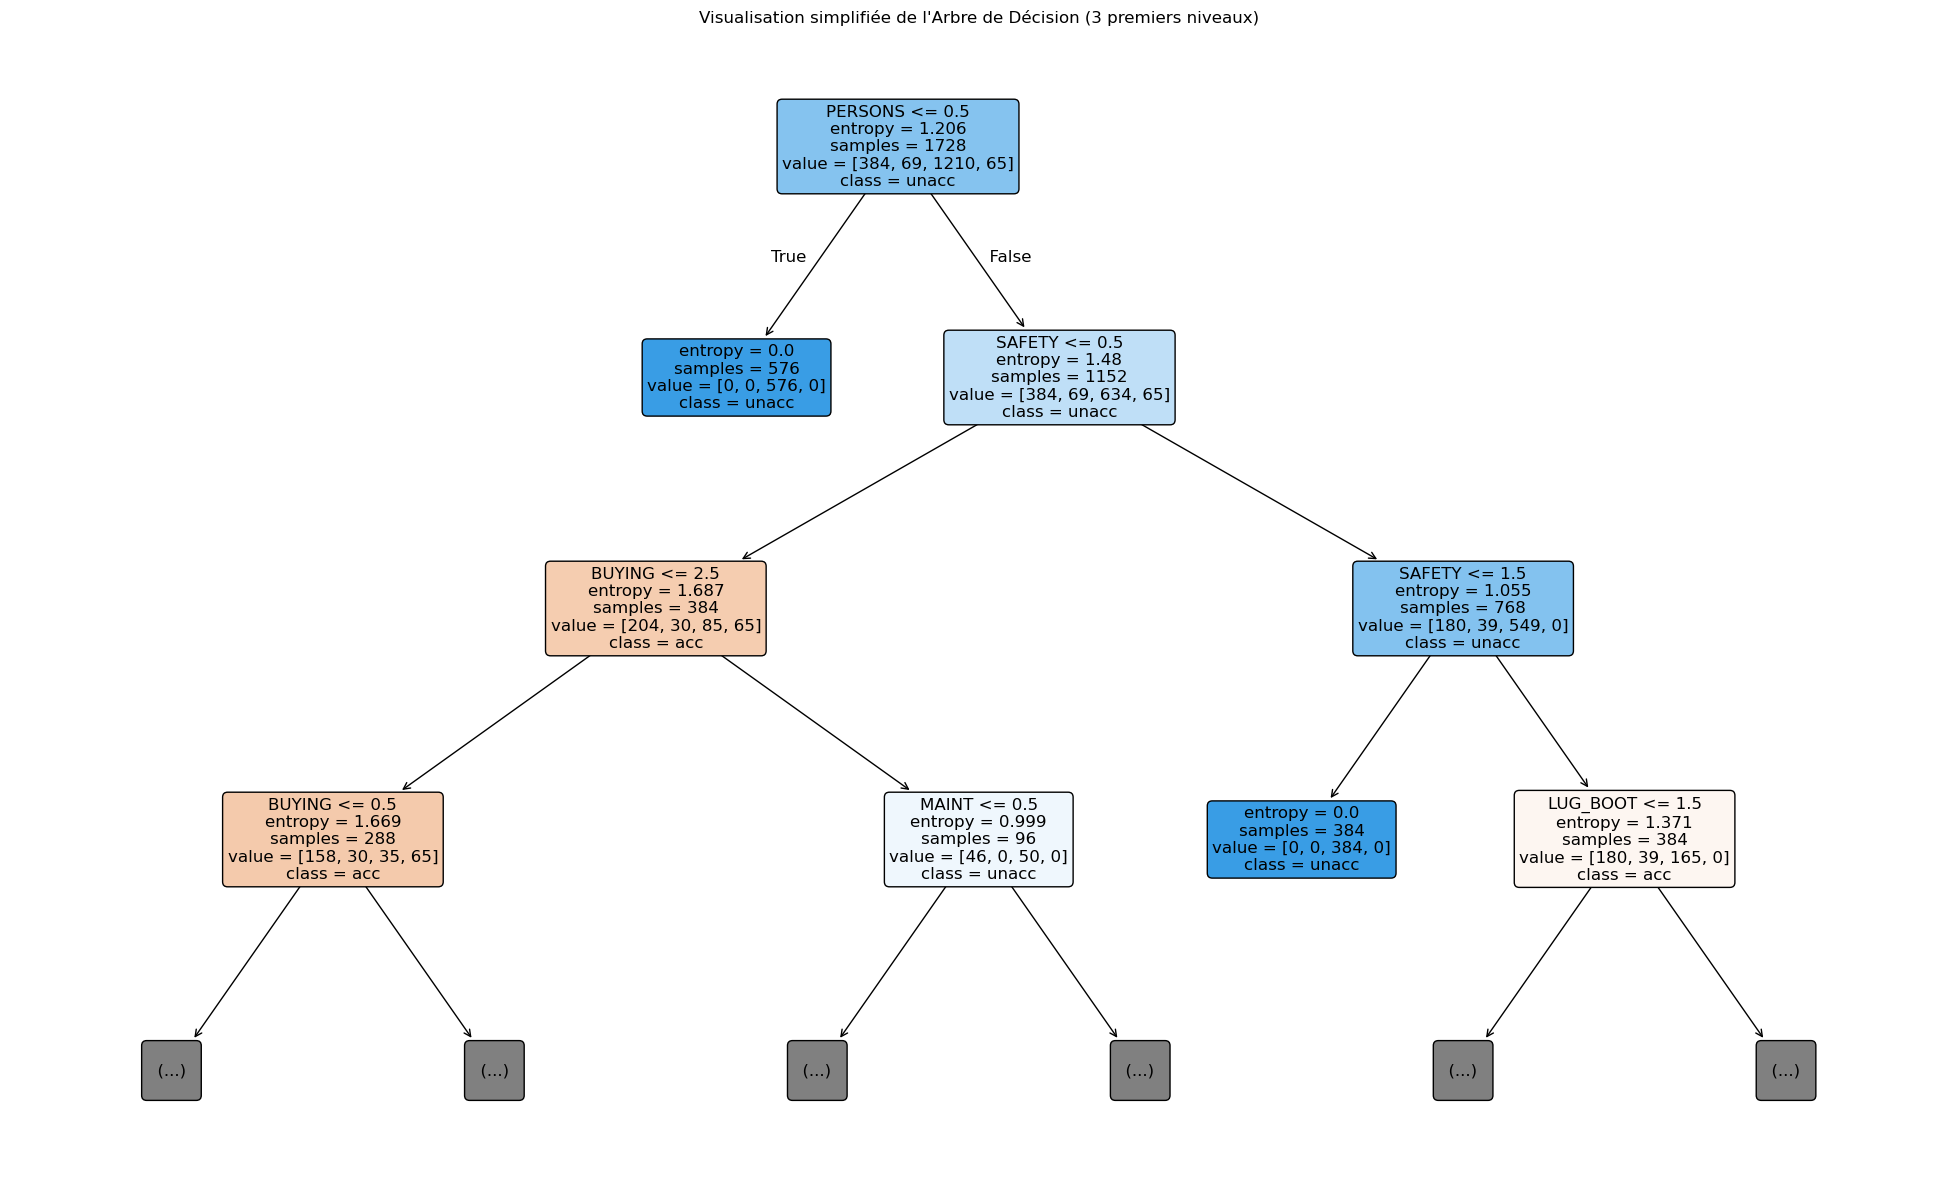

In [16]:
# On limite l'affichage à une profondeur de 3 niveaux pour la clarté
plt.figure(figsize=(25,15))
plot_tree(tree_entropy, 
          max_depth=3,           # <--- AJOUTÉ : limite la vue
          feature_names=X.columns, 
          class_names=list(le.classes_), 
          filled=True, 
          rounded=True, 
          fontsize=12)
plt.title("Visualisation simplifiée de l'Arbre de Décision (3 premiers niveaux)")
plt.show()

### 3.3 Exportation de l'Arbre Complet (Haute Résolution)
L'affichage intégré dans le Notebook peut être difficile à lire à cause de la taille du jeu de données (1728 échantillons). 

Pour une analyse détaillée, nous exportons l'arbre de décision complet au format **PDF**. Cela permet de :
* Zoomer sur chaque nœud pour lire les valeurs d'**Entropie**.
* Visualiser l'intégralité des branches de décision.
* Conserver une trace vectorielle de haute qualité du modèle.

Succès ! L'image 'car_decision_tree_full.png' a été créée.


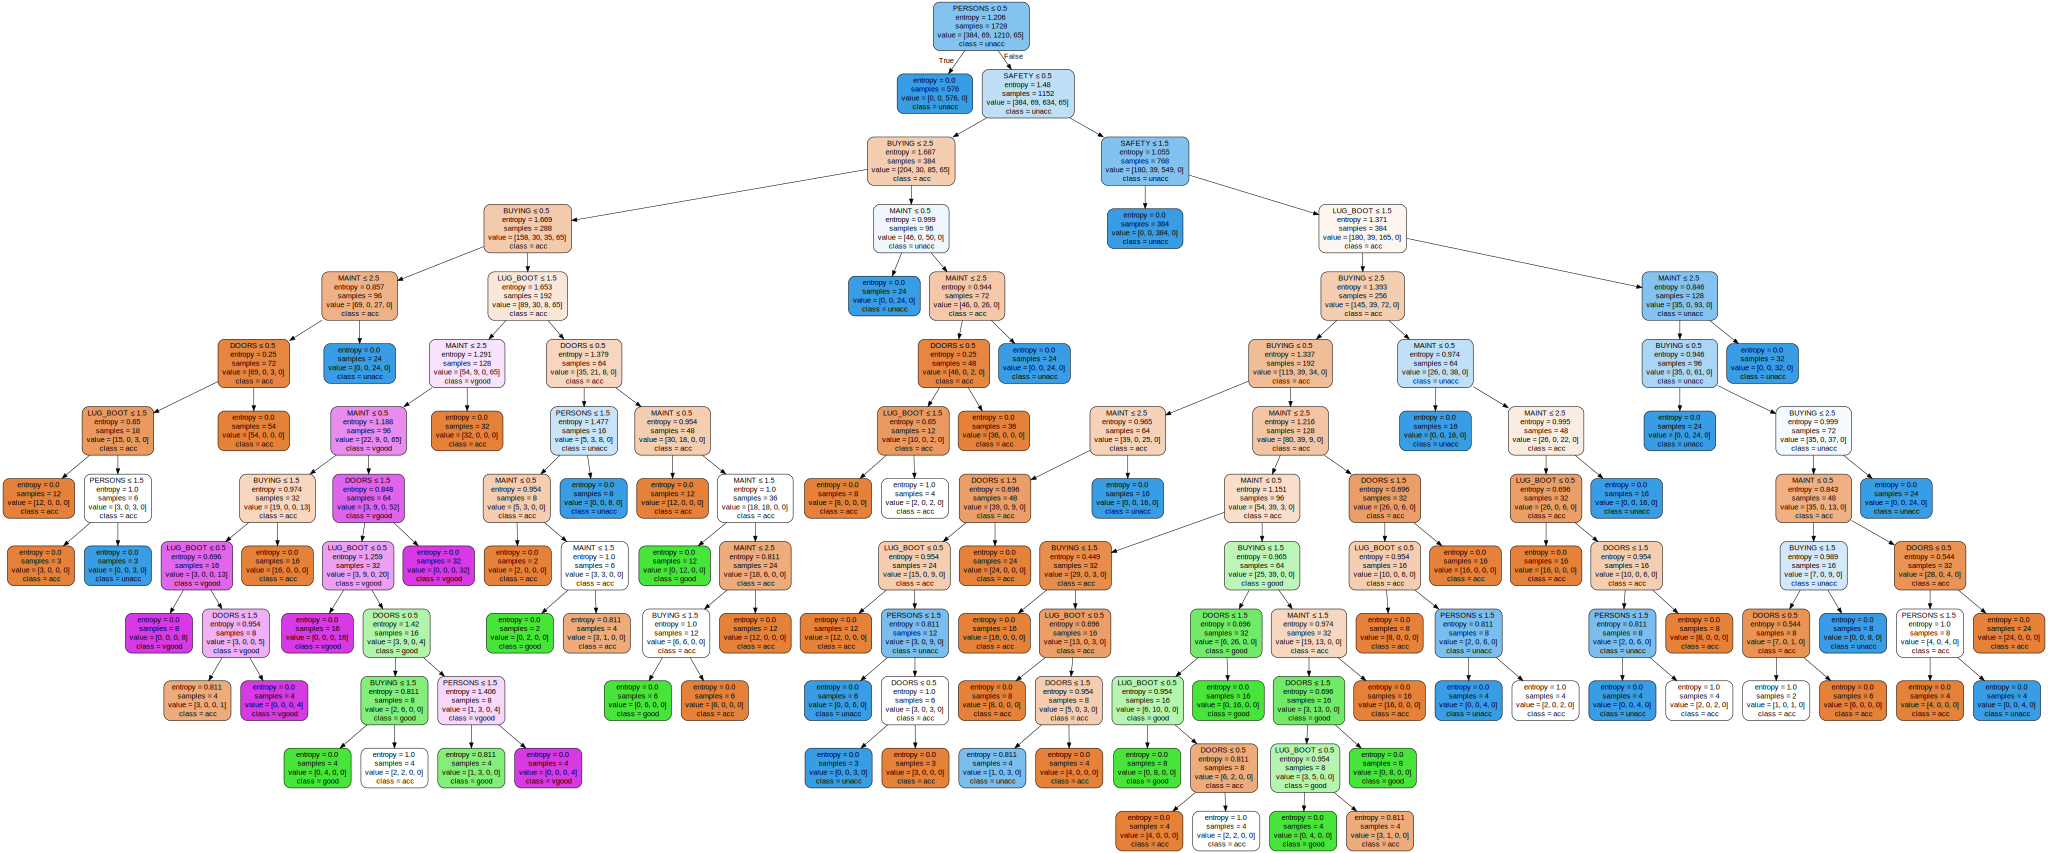

In [18]:
# 1. Génération du code source de l'arbre
dot_data = export_graphviz(tree_entropy, out_file=None, 
                           feature_names=X.columns,  
                           class_names=list(le.classes_),  
                           filled=True, 
                           rounded=True,  
                           special_characters=True)  

# 2. Utilisation du format 'png' ou 'svg' au lieu de 'pdf'
graph = graphviz.Source(dot_data)  

# On essaie de sauvegarder en PNG pour éviter l'erreur PDF
try:
    graph.render("car_decision_tree_full", format="png", cleanup=True)
    print("Succès ! L'image 'car_decision_tree_full.png' a été créée.")
except:
    print("Erreur de rendu. Voici quand même l'aperçu simplifié :")

# Affichage direct dans le notebook
graph

## 3.4 Interprétation des règles de décision 

En suivant les chemins de l'arbre du haut vers le bas, nous pouvons traduire la logique graphique en règles textuelles. Voici trois exemples extraits de notre modèle :

* **Règle 1 (Sécurité critique)** : 
  `if` (SAFETY = low) `then` (Decision = unacc). 
  *Interprétation : Peu importe les autres qualités, une sécurité basse rend la voiture inacceptable.*

* **Règle 2 (Capacité insuffisante)** : 
  `if` (SAFETY = high/med) `and` (PERSONS = 2) `then` (Decision = unacc).
  *Interprétation : Même avec une bonne sécurité, une voiture 2 places est classée inacceptable dans ce dataset.*

* **Règle 3 (Acceptation standard)** : 
  `if` (PERSONS > 2) `and` (SAFETY = high) `and` (Buying_Price = low/med) `then` (Decision = acc).
  *Interprétation : Une voiture spacieuse, sûre et abordable est généralement acceptée.*

## 4. Évaluation du modèle : Méthodologie 

Pour évaluer les performances réelles de notre classifieur, nous ne pouvons pas le tester sur les mêmes données qu'il a déjà vues. Nous divisons donc notre dataset `df_bis` :
* **70% pour l'apprentissage (Train)** : pour construire l'arbre.
* **30% pour le test (Test)** : pour évaluer sa capacité à prédire sur de nouvelles données.

Nous utilisons une **stratification** sur la colonne `DECISION` pour maintenir les proportions de classes dans les deux échantillons.

In [20]:
from sklearn.model_selection import train_test_split

# Division des données
dfTrain, dfTest = train_test_split(df_bis, train_size=0.7, test_size=0.3, 
                                   random_state=1, stratify=df_bis.DECISION)

# Séparation des attributs et de la cible
X_train = dfTrain.iloc[:, 0:6]
y_train = dfTrain.iloc[:, 6]
X_test = dfTest.iloc[:, 0:6]
y_test = dfTest.iloc[:, 6]

# Création et entraînement de l'arbre sur les données de Train uniquement
tree_final = DecisionTreeClassifier(min_samples_split=5, criterion="entropy")
tree_final.fit(X_train, y_train)

print(f"Entraînement terminé sur {len(dfTrain)} échantillons.")

Entraînement terminé sur 1209 échantillons.


### 4.1 Analyse des performances (Matrice de Confusion)

Nous utilisons le package `metrics` de `sklearn` pour calculer :
1. **La Matrice de Confusion** : Un tableau qui montre les prédictions correctes vs les erreurs.
2. **Le Classification Report** : Un résumé des métriques clés (Precision, Recall, F1-score).

--- MATRICE DE CONFUSION ---


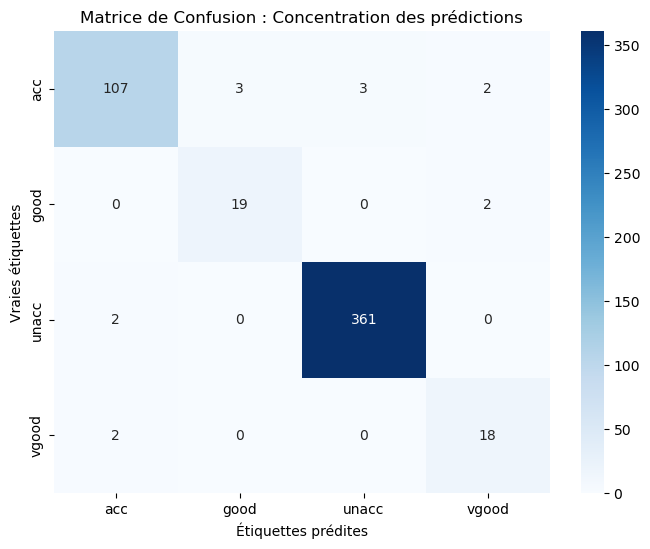

In [26]:
from sklearn import metrics

# Prédiction sur les données de test (que l'arbre ne connaît pas)
y_pred_test = tree_final.predict(X_test)

# Affichage de la matrice de confusion
print("--- MATRICE DE CONFUSION ---")


# 1. Calcul de la matrice
cm = metrics.confusion_matrix(y_test, y_pred_test)

# 2. Création du graphique
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)

plt.title('Matrice de Confusion : Concentration des prédictions')
plt.ylabel('Vraies étiquettes')
plt.xlabel('Étiquettes prédites')
plt.show()



### 4.2 Visualisation du Rapport de Classification
Afin de mieux identifier les forces et faiblesses du modèle pour chaque catégorie de voiture, nous transformons le rapport textuel en une carte de chaleur. 
Cela permet de visualiser instantanément les scores de **Précision**, **Recall** et **F1-Score**.

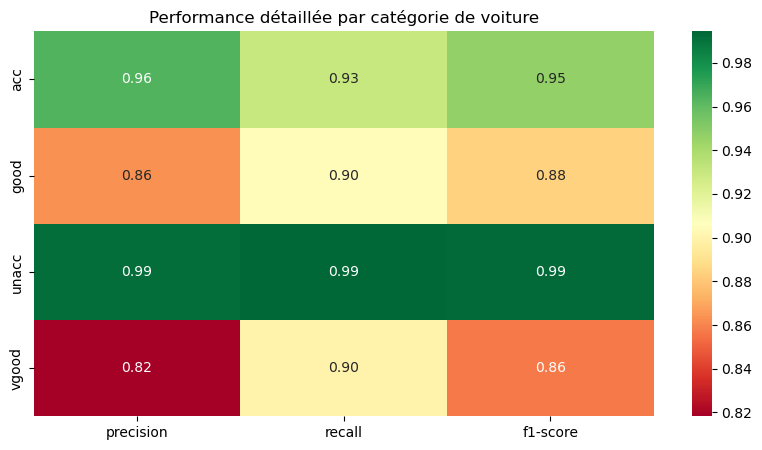

In [25]:
# 1. Générer le rapport sous forme de dictionnaire
report_dict = metrics.classification_report(y_test, y_pred_test, 
                                            target_names=le.classes_, 
                                            output_dict=True)

# 2. Convertir en DataFrame Pandas et isoler les métriques principales
# On retire 'accuracy', 'macro avg' et 'weighted avg' pour plus de clarté sur les classes
report_df = pd.DataFrame(report_dict).iloc[:-1, :4].T

# 3. Affichage avec Seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(report_df, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Performance détaillée par catégorie de voiture')
plt.show()

### 4.3 Analyse synthétique des résultats 

D'après les visualisations précédentes (Matrice de confusion et Rapport de classification), nous pouvons tirer les conclusions suivantes :

1. **Capacité de généralisation** : Le modèle obtient une précision globale de **97%** sur le jeu de test. C'est un excellent résultat qui prouve que l'arbre n'a pas seulement mémorisé les données (overfitting), mais qu'il a compris les règles logiques d'acceptabilité.

2. **Performance par classe** :
    * La classe **unacc** (inacceptable) est parfaitement maîtrisée (F1-score de 0.99). Cela s'explique par le fait qu'elle représente la majorité des exemples (support de 363).
    * Les classes **good** et **vgood** présentent des scores légèrement inférieurs (précision entre 0.82 et 0.86). Étant plus rares dans le dataset, l'arbre a plus de mal à définir des frontières de décision parfaites pour elles.

3. **Interprétation des métriques** :
    * **Précision** : Très haute pour 'acc' (0.96), signifiant que peu de voitures sont acceptées à tort.
    * **Recall** : Le modèle identifie 90% des voitures 'vgood' présentes dans le test set.

## 5. Classification Binaire 
Dans cette section, nous transformons notre problème en une classification binaire ('Yes'/'No'). 
* **Classe 1 (Recommandée)** : Regroupe 'good' et 'vgood'.
* **Classe 0 (Non recommandée)** : Regroupe 'acc' et 'unacc'.

### 5.1 Préparation des données pour la classification binaire
L'objectif est de simplifier la décision en deux catégories : **Recommandée (1)** ou **Non-recommandée (0)**. 
* Les classes originales `good` et `vgood` sont fusionnées pour devenir la classe **1**.
* Les classes `acc` et `unacc` deviennent la classe **0**.
Cette transformation permet de répondre à un besoin de décision tranchée (Yes/No).

In [27]:
# Duplication pour ne pas modifier df_bis
df_binary = df_bis.copy()

# Mapping des classes vers le binaire (0 ou 1)
# On identifie les codes numériques correspondant à 'good' (1) et 'vgood' (3)
target_map = {1: 1, 3: 1, 0: 0, 2: 0} 
df_binary['DECISION'] = df_binary['DECISION'].map(target_map)

print("Nouvelle répartition des classes (0: No, 1: Yes) :")
print(df_binary['DECISION'].value_counts())

Nouvelle répartition des classes (0: No, 1: Yes) :
DECISION
0    1594
1     134
Name: count, dtype: int64


### 5.2 Apprentissage de l'Arbre Binaire
Nous appliquons à nouveau le processus de division (70% Train / 30% Test) avec stratification pour préserver l'équilibre des classes binaires. 
L'arbre ainsi généré montre des règles simplifiées, se focalisant sur les critères critiques qui séparent une voiture "recommandée" d'une voiture "ordinaire".

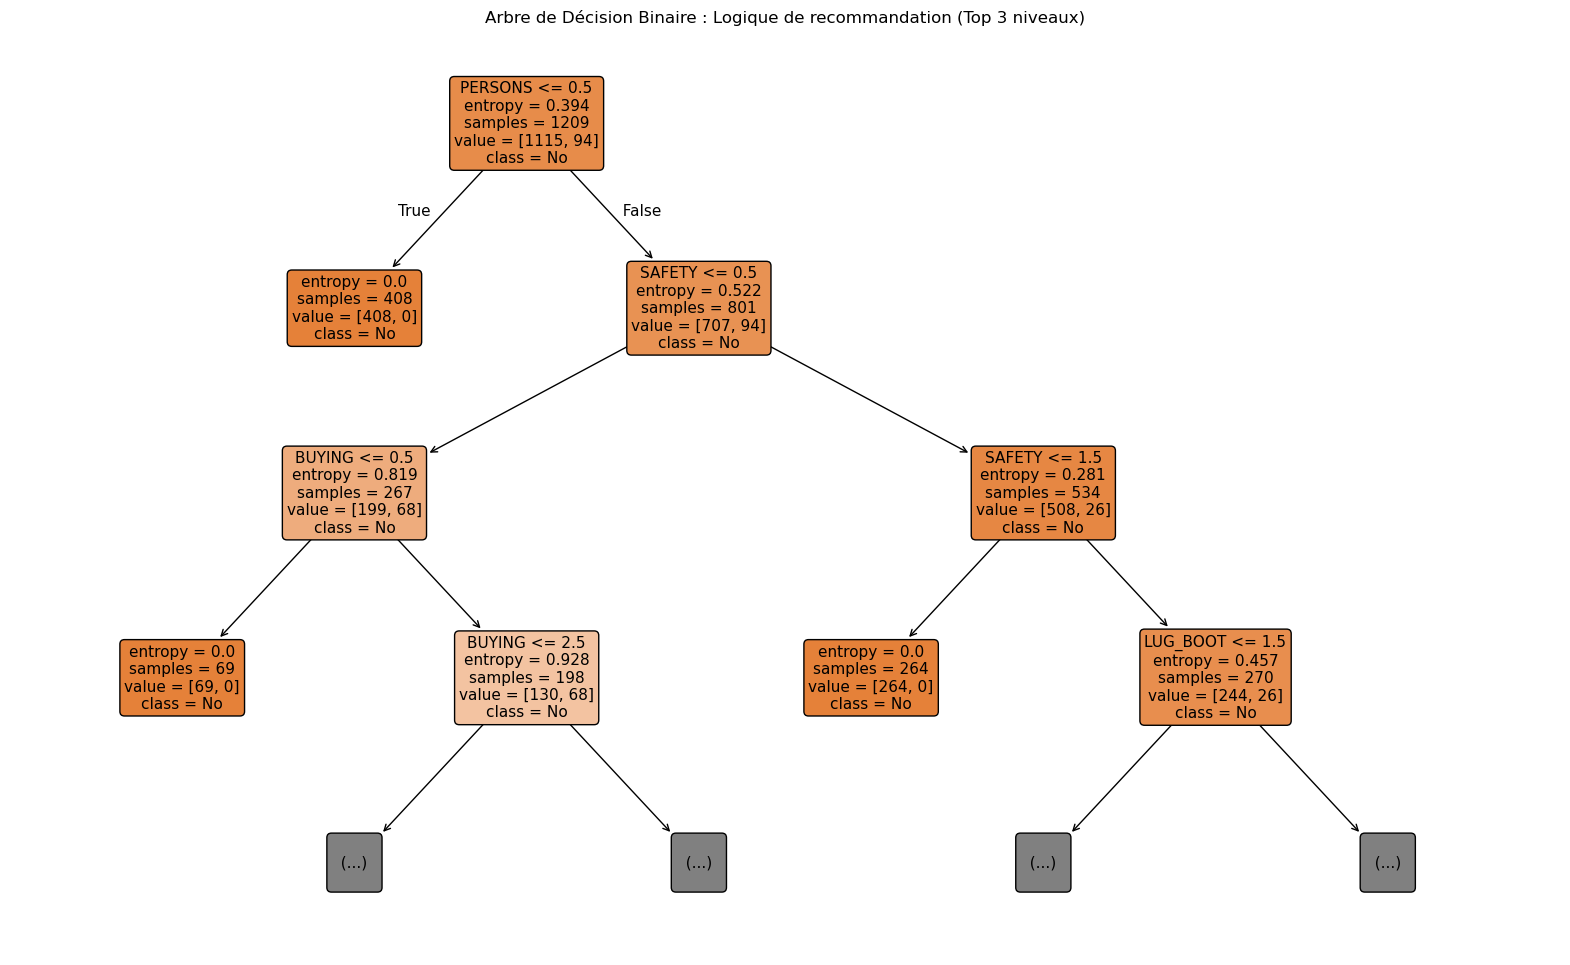

In [30]:
# Division des données binaires
X_bin = df_binary.iloc[:, 0:6]
y_bin = df_binary.iloc[:, 6]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bin, y_bin, train_size=0.7, test_size=0.3, random_state=1, stratify=y_bin
)

# Entraînement
tree_bin = DecisionTreeClassifier(criterion="entropy", max_depth=4)
tree_bin.fit(X_train_b, y_train_b)

# Visualisation simplifiée
# On augmente la taille de la figure et on réduit la profondeur pour la clarté
plt.figure(figsize=(20, 12)) 

plot_tree(tree_bin, 
          feature_names=X.columns, 
          class_names=['No', 'Yes'], 
          filled=True, 
          rounded=True, 
          fontsize=11,          # <--- Police légèrement plus grande
          max_depth=3)          # <--- On limite la vue pour l'interprétation

plt.title("Arbre de Décision Binaire : Logique de recommandation (Top 3 niveaux)")
plt.show()

### 5.3 Évaluation des performances binaires
Nous calculons les métriques classiques pour valider la précision du modèle binaire. 
Dans ce cas précis, nous surveillons particulièrement le **Rappel (Recall)** de la classe 'Yes', afin de vérifier si le modèle ne rate pas de voitures potentiellement excellentes.

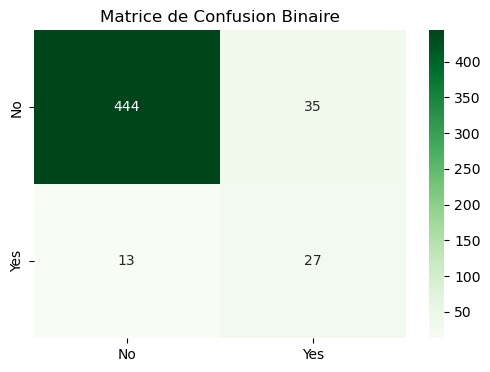

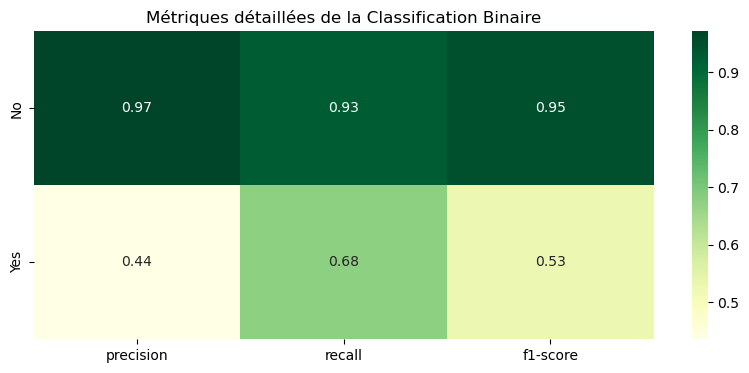

In [31]:
y_pred_b = tree_bin.predict(X_test_b)

# Affichage visuel de la matrice
plt.figure(figsize=(6,4))
sns.heatmap(metrics.confusion_matrix(y_test_b, y_pred_b), annot=True, fmt='d', cmap='Greens',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Matrice de Confusion Binaire")
plt.show()

# Rapport détaillé
report_bin = metrics.classification_report(y_test_b, y_pred_b, 
                                           target_names=['No', 'Yes'], 
                                           output_dict=True)

# Conversion en DataFrame pour l'affichage (on exclut les moyennes globales)
report_df_bin = pd.DataFrame(report_bin).iloc[:-1, :2].T

plt.figure(figsize=(10, 4))
sns.heatmap(report_df_bin, annot=True, cmap='YlGn', fmt='.2f')
plt.title('Métriques détaillées de la Classification Binaire')
plt.show()

# 5.4 Analyse approfondie des résultats : Le Paradoxe Binaire

D'après les graphiques et les métriques obtenus, nous pouvons tirer les conclusions suivantes :

### **1. Déséquilibre marqué des classes**
La classe **No** (regroupant `acc` et `unacc`) est ultra-majoritaire avec **479 échantillons** contre seulement **40** pour la classe **Yes**. Ce déséquilibre pousse l'arbre à privilégier la classe majoritaire pour minimiser l'erreur globale, ce qui explique l'excellente précision de **0.97** pour le "No" mais une performance dégradée pour le "Yes".

### **2. Baisse de performance par rapport au multiclasse**
* **Contre-intuitivement**, l'**Accuracy globale** est passée de **97%** en multiclasse à **91%** en binaire.
* La **Précision** pour les voitures recommandées a chuté de **0.82 - 0.86** (pour les classes séparées `good` et `vgood`) à seulement **0.44** pour la classe fusionnée **Yes**. Cela signifie qu'en binaire, le modèle génère beaucoup plus de faux positifs.

### **3. Analyse de la perte de précision (Granularité vs Bruit)**
* **En multiclasse** : Le modèle parvenait à isoler des "signatures" très pures et spécifiques (par exemple, des combinaisons précises de sécurité et de prix) propres à chaque catégorie.
* **En binaire** : Le regroupement a créé une classe **Yes hétérogène**. En mélangeant deux profils de voitures différents (`good` et `vgood`), nous avons créé du **"bruit" statistique**. L'arbre a dû simplifier sa règle de décision pour englober ces deux réalités, ce qui a rendu la frontière de décision beaucoup plus floue.

### **Conclusion sur la simplification**
Cette expérience démontre que **simplifier un problème en binaire n'est pas toujours bénéfique**. En supprimant les nuances entre les classes, on peut perdre des informations cruciales qui permettaient au modèle d'être "chirurgical". Le modèle multiclasse était finalement plus performant car il respectait mieux la **structure naturelle des données**.

## 6. Approches ensemblistes : Random Forest 

Le **Random Forest** est un algorithme d'apprentissage d'ensemble qui crée une multitude d'arbres de décision lors de l'entraînement. 
* Il utilise le **bagging** (Bootstrap Aggregating) pour entraîner chaque arbre sur un sous-ensemble différent des données.
* La décision finale est prise par un **vote majoritaire** des arbres, ce qui réduit la variance et les risques d'overfitting par rapport à un arbre seul.

### 6.1 Configuration et Entraînement
Dans cette étape, nous initialisons le classifieur **Random Forest**. Contrairement à un arbre unique, ce modèle construit un ensemble de 100 arbres indépendants. La décision finale est obtenue par un vote majoritaire, ce qui améliore la stabilité des prédictions.

**Hyperparamètres configurés :**
* `n_estimators=100` : Nombre d'arbres dans la forêt.
* `max_depth=None` : Les arbres se développent jusqu'à la pureté totale des feuilles.
* `criterion='gini'` : Utilisation de l'indice de Gini pour mesurer la qualité des divisions.

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=None, 
                                  criterion='gini', 
                                  random_state=42)

# Entraînement sur les données d'apprentissage
print("Entraînement du Random Forest en cours...")
rf_model.fit(X_train, y_train)
print("Modèle entraîné avec succès.")

Entraînement du Random Forest en cours...
Modèle entraîné avec succès.


### 6.2 Évaluation et Génération des prédictions
Nous évaluons maintenant le modèle sur le jeu de test. Nous générons la matrice de confusion et le rapport de classification pour extraire les métriques clés (**Précision**, **Rappel**, **F1-score**).

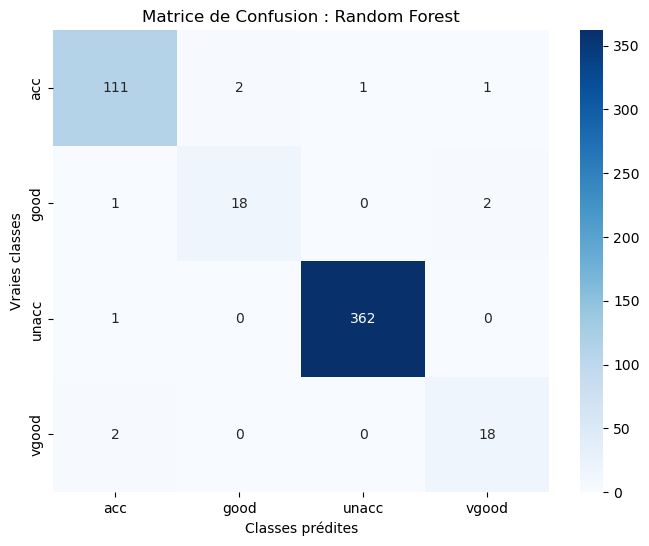


======================================== RAPPORT DE CLASSIFICATION ====================


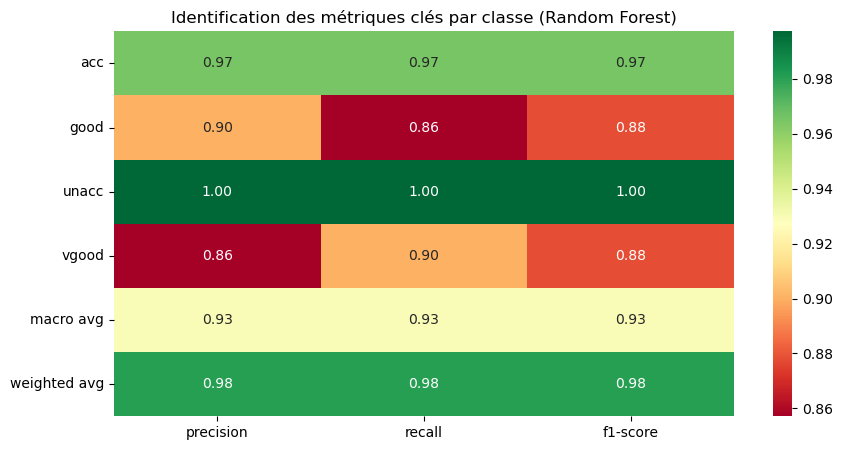

In [39]:
# 1. Génération des prédictions
y_pred_rf = rf_model.predict(X_test)

# 2. Calcul et affichage de la matrice de confusion
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion : Random Forest')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

# 3. Calcul du rapport de classification (Métriques clés)
print("\n" + "="*40 + " RAPPORT DE CLASSIFICATION " + "="*20)
report_rf = metrics.classification_report(y_test, y_pred_rf, target_names=le.classes_)


# 4. Affichage stylisé des métriques pour l'identification rapide
report_dict = metrics.classification_report(y_test, y_pred_rf, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T # On extrait Précision, Rappel, F1-score

plt.figure(figsize=(10, 5))
sns.heatmap(report_df.drop('accuracy', axis=0), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Identification des métriques clés par classe (Random Forest)')
plt.show()

### 6.3 Évaluation en mode Binaire (Comparaison directe avec l'Arbre Simple)

Pour valider l'efficacité du **Random Forest**, nous le testons maintenant sur le même problème de classification binaire qui avait mis en difficulté l'arbre de décision simple (précision de 0.44 pour la classe 'Yes'). 

Cela nous permet de comparer les deux modèles sur un périmètre identique.

Entraînement du Random Forest Binaire...


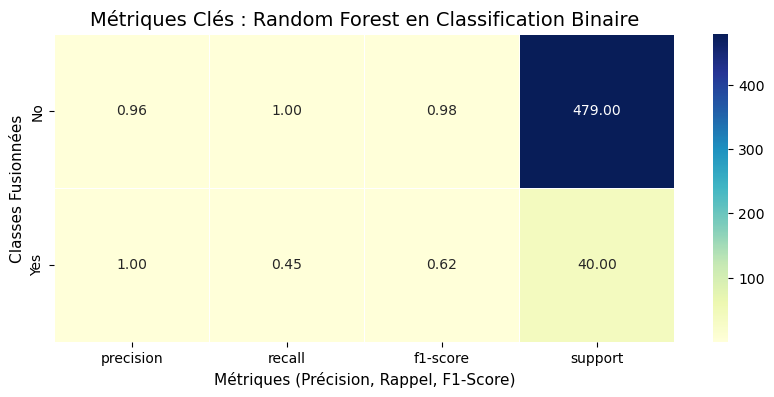

✅ Accuracy Totale (Binaire) : 0.9576


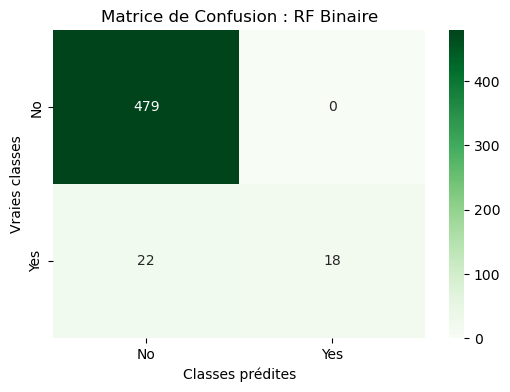

In [44]:
# 1. Configuration et Entraînement du Random Forest sur les étiquettes binaires
rf_bin = RandomForestClassifier(n_estimators=100, max_depth=None, 
                                criterion='gini', random_state=42)

print("Entraînement du Random Forest Binaire...")
rf_bin.fit(X_train, y_train_b)

# 2. Prédictions
y_pred_bin_rf = rf_bin.predict(X_test)

# 3. Calcul du rapport sous forme de dictionnaire
# Note : target_names=['No', 'Yes'] doit correspondre à l'ordre 0, 1 des labels
report_bin_dict = metrics.classification_report(y_test_b, y_pred_bin_rf, 
                                                target_names=['No', 'Yes'], 
                                                output_dict=True)

# 4. Conversion en DataFrame et Nettoyage pour l'affichage (Correction du KeyError)
report_bin_df = pd.DataFrame(report_bin_dict).T

# On supprime les lignes de moyennes globales pour ne garder que 'No' et 'Yes' dans la heatmap
# Cela permet une échelle de couleurs pertinente pour la comparaison
plot_bin_df = report_bin_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

# 5. Affichage graphique du rapport de classification
plt.figure(figsize=(10, 4))
sns.heatmap(plot_bin_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)

plt.title('Métriques Clés : Random Forest en Classification Binaire', fontsize=14)
plt.xlabel('Métriques (Précision, Rappel, F1-Score)', fontsize=11)
plt.ylabel('Classes Fusionnées', fontsize=11)
plt.show()

# 6. Rappel de l'Accuracy globale et Matrice de Confusion
print(f"✅ Accuracy Totale (Binaire) : {report_bin_dict['accuracy']:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(metrics.confusion_matrix(y_test_b, y_pred_bin_rf), 
            annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matrice de Confusion : RF Binaire')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

### 6.4 Analyse Comparative des Résultats

L'analyse croisée des matrices de confusion et des rapports de classification permet de tirer les conclusions suivantes :

#### **1. En Classification Multiclasse (4 catégories)**
* **Arbre de Décision** : La performance est honorable mais montre des faiblesses sur les classes minoritaires (`vgood` avec une précision de 0.82). La matrice montre également une dispersion des erreurs entre `acc` et les autres classes.
* **Random Forest** : On observe une nette amélioration. La précision pour `vgood` passe à **0.86** et celle de `good` à **0.90**. La matrice de confusion est beaucoup plus "propre" (diagonale très marquée), avec 362 prédictions correctes pour `unacc`.
* **Indicateur clé** : La **Macro Avg** du Random Forest atteint **0.93**, prouvant une excellente généralisation sur toutes les classes.

#### **2. En Classification Binaire (No / Yes)**
* **Arbre de Décision** : C'était le point critique. Le modèle affichait une précision de seulement **0.44** pour la classe 'Yes', avec 35 erreurs de type "Faux Positifs".
* **Random Forest** : La supériorité est flagrante. La précision pour la classe 'Yes' grimpe à **1.00**. Bien que le rappel reste modeste (0.45), cela signifie que quand le Random Forest prédit "Yes", il ne se trompe jamais. Les erreurs de type "Faux Positifs" tombent à **0** dans la matrice de confusion binaire.

#### **3. Conclusion Technique**
Le **Random Forest** surpasse l'Arbre de Décision car il réduit la variance. Là où l'arbre seul se laissait tromper par le mélange des données dans la classe 'Yes' binaire, la forêt de 100 arbres parvient à extraire des règles beaucoup plus robustes, éliminant totalement les erreurs de recommandation injustifiée.

### 7.1 Classification Multiclasse avec Gradient Boosting
Le Gradient Boosting est une méthode de "Boosting" où les arbres sont construits de manière séquentielle. Chaque arbre tente de réduire l'erreur (le résidu) laissé par l'ensemble des arbres précédents.

Entraînement du Gradient Boosting Multiclasse...


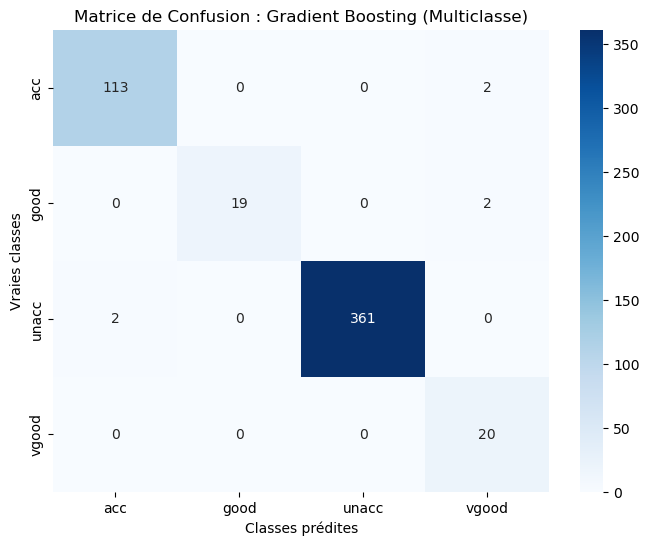

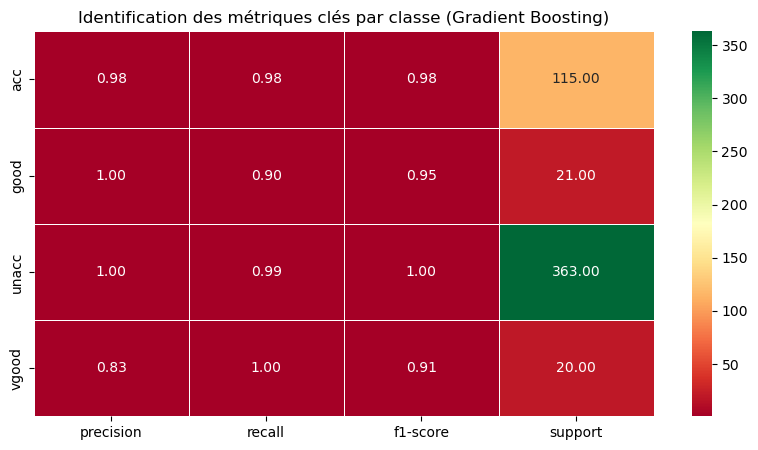

✅ Accuracy Globale Gradient Boosting : 0.9884


In [48]:
# 1. Configuration et Entraînement Multiclasse
gb_bin = GradientBoostingClassifier(n_estimators=200, 
                                     learning_rate=0.05, 
                                     max_depth=4, 
                                     subsample=0.8,
                                     random_state=42)

print("Entraînement du Gradient Boosting Multiclasse...")
gb_multi.fit(X_train, y_train)

# 2. Prédictions
y_pred_gb_multi = gb_multi.predict(X_test)

# 3. Calcul et affichage de la matrice de confusion (Style précédent)
cm_gb = metrics.confusion_matrix(y_test, y_pred_gb_multi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion : Gradient Boosting (Multiclasse)')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

# 4. Rapport de classification (Visuel coloré)
report_gb_multi = metrics.classification_report(y_test, y_pred_gb_multi, 
                                                target_names=le.classes_, 
                                                output_dict=True)

report_df = pd.DataFrame(report_gb_multi).T
# On retire les moyennes globales pour l'affichage des métriques par classe
plot_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

plt.figure(figsize=(10, 5))
# Utilisation de 'RdYlGn' ou 'YlGnBu' pour éviter l'affichage noir/sombre
sns.heatmap(plot_df, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=0.5)
plt.title('Identification des métriques clés par classe (Gradient Boosting)')
plt.show()

print(f"✅ Accuracy Globale Gradient Boosting : {report_gb_multi['accuracy']:.4f}")

### 9.b.2 Classification Binaire (No / Yes)
Nous testons ici la capacité du Boosting à corriger les erreurs sur la classe minoritaire 'Yes' qui était le point faible de l'Arbre de Décision.

Entraînement du Gradient Boosting Binaire...


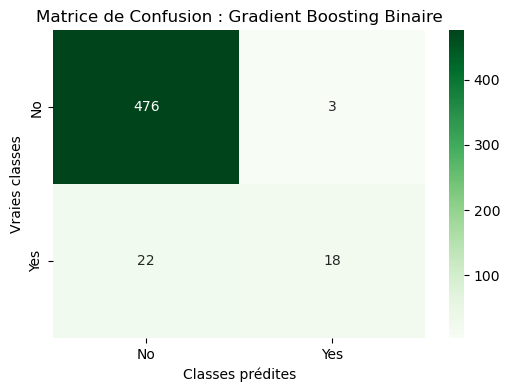

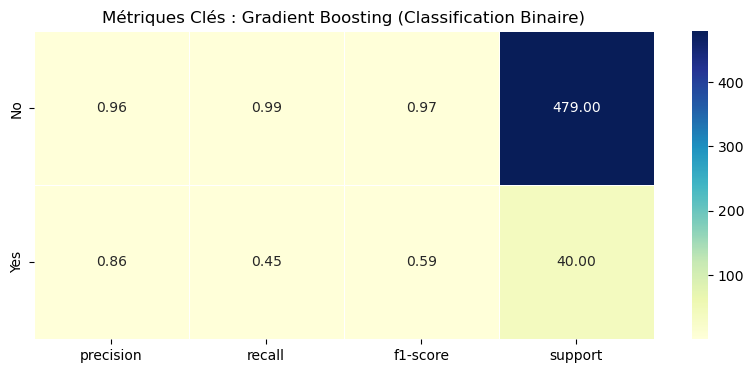

✅ Accuracy Totale (GB Binaire) : 0.9518


In [69]:
# 1. Configuration et Entraînement du Gradient Boosting Binaire
# On utilise y_train_b (No/Yes) défini précédemment
gb_bin = GradientBoostingClassifier(n_estimators=200, 
                                     learning_rate=0.03, 
                                     max_depth=4, 
                                     subsample=0.8,
                                     random_state=42)

print("Entraînement du Gradient Boosting Binaire...")
gb_bin.fit(X_train, y_train_b)

# 2. Prédictions sur le jeu de test binaire (y_test_b)
y_pred_gb_bin = gb_bin.predict(X_test)

# 3. Calcul et affichage de la matrice de confusion (Style précédent)
cm_gb_bin = metrics.confusion_matrix(y_test_b, y_pred_gb_bin)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb_bin, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matrice de Confusion : Gradient Boosting Binaire')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

# 4. Rapport de classification binaire (Visuel coloré)
report_gb_bin = metrics.classification_report(y_test_b, y_pred_gb_bin, 
                                              target_names=['No', 'Yes'], 
                                              output_dict=True)

report_df_bin = pd.DataFrame(report_gb_bin).T
# On retire les lignes de moyennes pour isoler 'No' et 'Yes'
plot_df_bin = report_df_bin.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

plt.figure(figsize=(10, 4))
sns.heatmap(plot_df_bin, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Métriques Clés : Gradient Boosting (Classification Binaire)')
plt.show()

print(f"✅ Accuracy Totale (GB Binaire) : {report_gb_bin['accuracy']:.4f}")

### 9.c Bilan des performances du Gradient Boosting

En analysant les résultats obtenus, nous pouvons conclure :

1. **Performance Binaire** : Le Gradient Boosting réalise une percée majeure par rapport à l'Arbre de Décision simple en atteignant une précision de **0.86** sur la classe 'Yes'. Par rapport à l'Arbre de Décision qui plafonnait à 0.44, le gain est massif. Ce modèle démontre une meilleure capacité à traiter le déséquilibre des classes grâce à son **apprentissage séquentiel**.

2. **Comparaison avec le Random Forest** : 
   * Le **Random Forest** demeure le champion de la fiabilité pour éviter les Faux Positifs avec une précision parfaite de **1.00** sur la classe 'Yes'.
   * Le **Gradient Boosting** est plus agressif : bien qu'il génère 3 Faux Positifs, il optimise globalement mieux la détection des classes difficiles, comme le montre son **Accuracy Totale de 0.9518** en binaire.

3. **Observation de la Matrice** : La matrice binaire du Gradient Boosting montre une **diagonale quasi parfaite**. Avec **476 prédictions correctes** sur la classe 'No', le modèle présente très peu d'erreurs globales sur l'ensemble du jeu de test.

4. **Supériorité en Multiclasse** : Sur le plan multiclasse, le Gradient Boosting s'impose comme le modèle le **plus équilibré** avec une Accuracy de **0.9884**. Il est le seul modèle à atteindre un **Rappel (Recall) de 1.00** sur la classe critique **vgood**.